In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from collections import defaultdict
from statistics import mean
from functools import reduce

Using TensorFlow backend.
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

# Load DataSet

In [2]:
df_addr = "articles_by_year_number_of_authors_percentage_summery.pkl"

In [3]:
df = pd.read_pickle(df_addr)

In [4]:
df = df.apply(lambda x: x / 100)[:"2018"]

In [5]:
df

num_of_authors,1,2,3,4,5,6,7,8,9
year,,,,,,,,,
1936,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1937,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1938,0.900000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1939,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1940,0.800000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2014,0.101589,0.248187,0.272674,0.189458,0.098353,0.045894,0.019739,0.009830,0.005281
2015,0.098366,0.236847,0.268703,0.192924,0.105060,0.050884,0.021504,0.010617,0.005571
2016,0.090670,0.229360,0.265254,0.197680,0.111165,0.054291,0.023577,0.011704,0.006001


# Create Models

## LSTM

In [6]:
def create_data(df, train_test_sep):
    total_data = df.values
    print("total data: %s" % (total_data.shape,))

    train_data = total_data[:-train_test_sep]
    print("train data: %s" % (train_data.shape,))

    test_data = total_data[-train_test_sep:]
    print("test data: %s" % (test_data.shape,))
    
    return train_data, test_data

In [7]:
def create_lookback_dataset(dataset, n, look_back):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back):
        featrues = np.concatenate(list(map(lambda x: x[n:n+1], dataset[i:(i + look_back)])))
        y = i / 100
        featrues = np.concatenate(([y], featrues, featrues * y))
        data_x.append(featrues)
        data_y.append(dataset[i + look_back][n])
    return np.array(data_x), np.array(data_y)

In [8]:
def prepare_data(data, time_steps, n):
    X, y = create_lookback_dataset(data, n - 1, time_steps)
    X = X.reshape((X.shape[0], len(X[0]), 1))
    print("X: %s,\ty: %s" % (X.shape, y.shape))
    return X, y

In [9]:
def train_model(X_train, y_train):
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)
    
    return model, history

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    print("last train loss: %s,\tlast test loss: %s" % (history.history['loss'][-1], history.history['val_loss'][-1]))

In [11]:
def plot_train_data(model, n, X_train, y_train, y_test, time_steps):
    time_axis = np.arange(2019 - len(y_test) - len(y_train) - time_steps, 2019 - len(y_test) - time_steps)
#     print(time_axis)
    plt.figure(figsize = (15,6))
    plt.plot(list(range(len(time_axis))), y_train * 100, color = 'red', label = 'Real')
    plt.plot(list(range(len(time_axis))), model.predict(X_train) * 100, color = 'blue', label = 'Predicted')
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)
    plt.title("Prediction over Train Data\nn = %s" % n)
    plt.xlabel('year')
    plt.ylabel('%% of articles with %s author(s)' % n)
    plt.legend()
    plt.show()

In [12]:
def plot_test_data(model, n, X_test, y_test):
    time_axis = np.arange(2019 - len(y_test), 2019)
#     print(time_axis)
    plt.figure(figsize = (15,6))
    plt.plot(list(range(len(time_axis))), y_test * 100, color = 'red', label = 'Real')
    plt.plot(list(range(len(time_axis))), model.predict(X_test) * 100, color = 'blue', label = 'Predicted')
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)
    plt.title("Prediction over Test Data\nn = %s" % n)
    plt.xlabel('year')
    plt.ylabel('%% of articles with %s author(s)' % n)
    plt.legend()
    plt.show()

In [13]:
def plot_train_test_data(model, n, X_train, y_train, X_test, y_test, time_steps):
    time_axis = np.concatenate((
        np.arange(2019 - len(y_test) - len(y_train) - time_steps, 2019 - len(y_test) - time_steps),
        np.arange(2019 - len(y_test), 2019)
    ))
#     print(time_axis)
    plt.figure(figsize = (25,6))
    plt.plot(list(range(len(time_axis))), np.concatenate((y_train, y_test)) * 100, color = 'red', label = 'Real')
    plt.plot(
        list(range(len(time_axis))),
        np.concatenate((model.predict(X_train).reshape(-1, 1), model.predict(X_test).reshape(-1, 1))) * 100,
        color = 'blue',
        label = 'Predicted'
    )
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)
    plt.title("Prediction over Train & Test Data\nn = %s" % n)
    plt.xlabel('year')
    plt.ylabel('%% of articles with %s author(s)' % n)
    plt.legend()
    plt.show()

In [14]:
def get_err(y_pred, y_test):
    return mean(np.square(y_pred - y_test))

In [15]:
def predict_one(train_data, test_data, time_steps, n):
    print("n = %s" % n)
    print("Train Data")
    X_train, y_train = prepare_data(train_data, time_steps, n)
    print("Test Data")
    X_test, y_test = prepare_data(test_data, time_steps, n)
    
    model, history = train_model(X_train, y_train)
    plot_loss(history)
    
    y_pred = model.predict(X_test)
    
    plot_train_data(model, n, X_train, y_train, y_test, time_steps)
    plot_test_data(model, n, X_test, y_test)
    plot_train_test_data(model, n, X_train, y_train, X_test, y_test, time_steps)
    
    y_pred = y_pred.reshape(-1)
    err = get_err(y_pred, y_test)
    print("AVG MSE Err: %s" % err)
    
    print()
    
    return err
    

In [16]:
def predict(df, train_test_sep, time_steps):
    train_data, test_data = create_data(df, train_test_sep)
    print()
    errs = [predict_one(train_data, test_data, time_steps, i + 1) for i in range(5)]
    print()
    print("AVG Total MSE Err: %s" % mean(errs))
    return mean(errs)

total data: (83, 9)
train data: (58, 9)
test data: (25, 9)

n = 1
Train Data
X: (53, 11, 1),	y: (53,)
Test Data
X: (20, 11, 1),	y: (20,)

Train on 37 samples, validate on 16 samples
Epoch 1/20
37/37 [==============================] - 1s 19ms/step - loss: 0.5037 - val_loss: 0.0569
Epoch 2/20
37/37 [==============================] - 0s 987us/step - loss: 0.1319 - val_loss: 0.0670
Epoch 3/20
37/37 [==============================] - 0s 943us/step - loss: 0.0748 - val_loss: 0.1002
Epoch 4/20
37/37 [==============================] - 0s 988us/step - loss: 0.0256 - val_loss: 0.0064
Epoch 5/20
37/37 [==============================] - 0s 963us/step - loss: 0.0420 - val_loss: 0.0050
Epoch 6/20
37/37 [==============================] - 0s 980us/step - loss: 0.0310 - val_loss: 0.0309
Epoch 7/20
37/37 [==============================] - 0s 935us/step - loss: 0.0139 - val_loss: 0.0900
Epoch 8/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0577
Epoch 9/20
37/37 [===

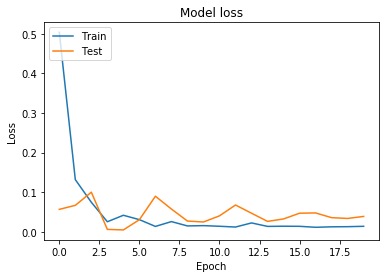

last train loss: 0.014145364909357316,	last test loss: 0.039080830523744226


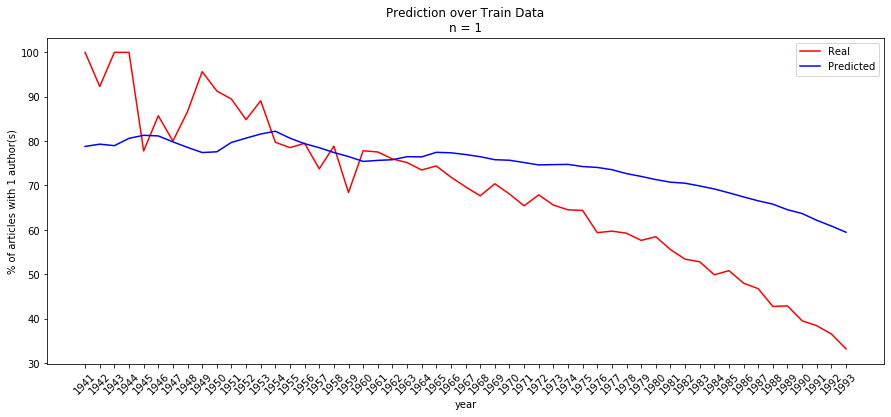

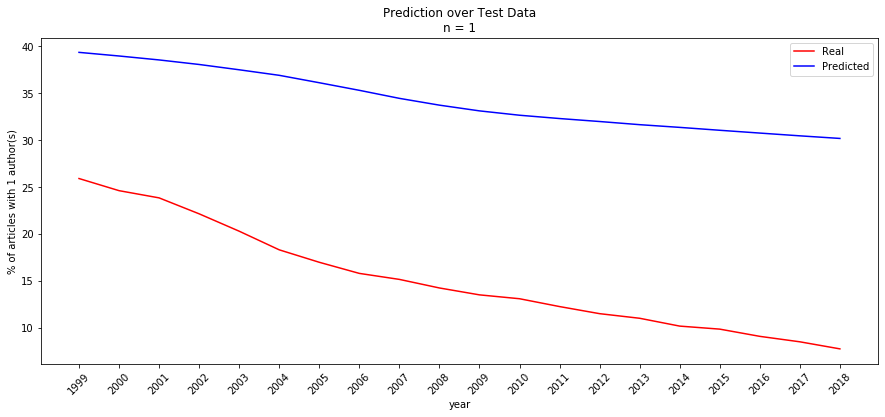

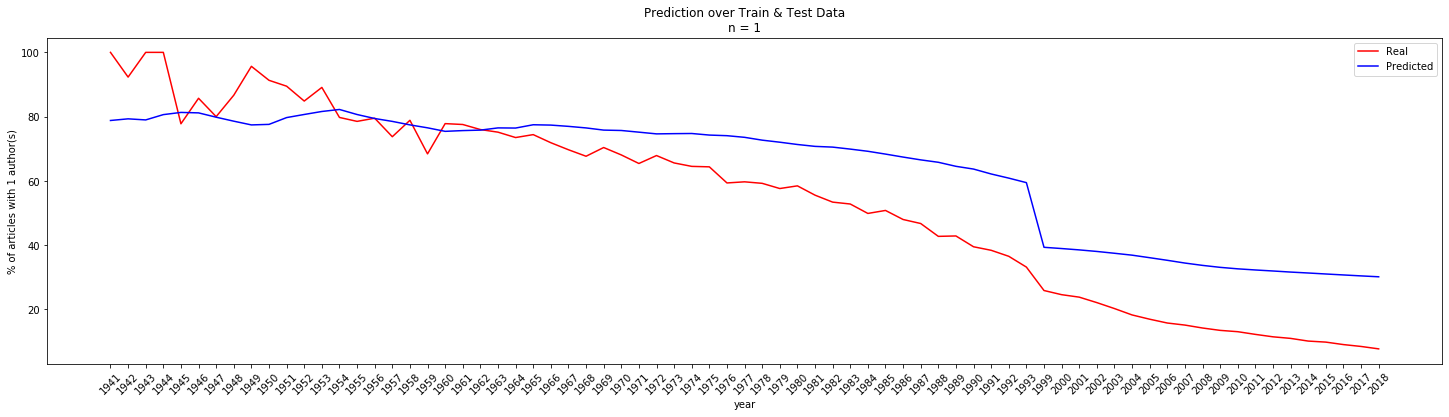

AVG MSE Err: 0.03682677045186232

n = 2
Train Data
X: (53, 11, 1),	y: (53,)
Test Data
X: (20, 11, 1),	y: (20,)
Train on 37 samples, validate on 16 samples
Epoch 1/20
37/37 [==============================] - 1s 16ms/step - loss: 0.0232 - val_loss: 0.0107
Epoch 2/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0016
Epoch 3/20
37/37 [==============================] - 0s 996us/step - loss: 0.0055 - val_loss: 0.0094
Epoch 4/20
37/37 [==============================] - 0s 964us/step - loss: 0.0058 - val_loss: 0.0163
Epoch 5/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0066
Epoch 6/20
37/37 [==============================] - 0s 939us/step - loss: 0.0030 - val_loss: 2.3895e-04
Epoch 7/20
37/37 [==============================] - 0s 919us/step - loss: 0.0040 - val_loss: 1.4430e-04
Epoch 8/20
37/37 [==============================] - 0s 952us/step - loss: 0.0031 - val_loss: 0.0023
Epoch 9/20
37/37 [========================

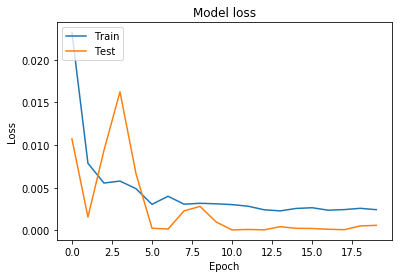

last train loss: 0.0024173287989420664,	last test loss: 0.0005809742251585703


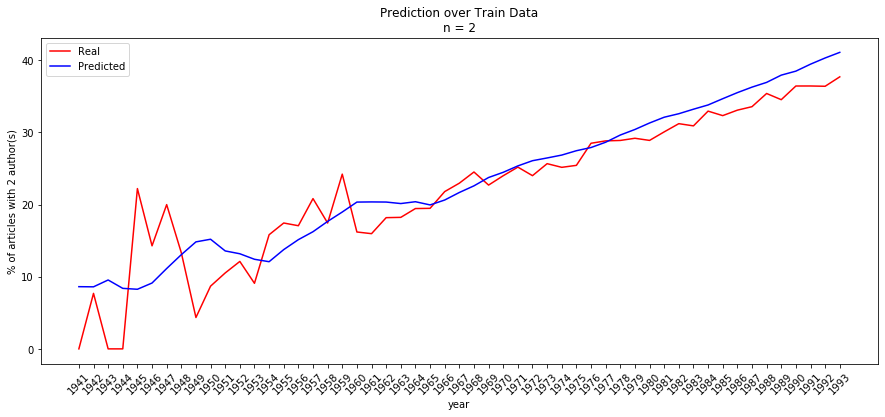

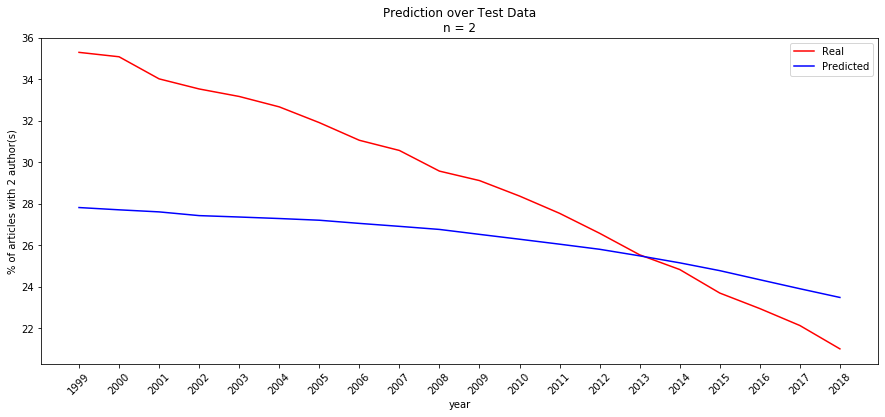

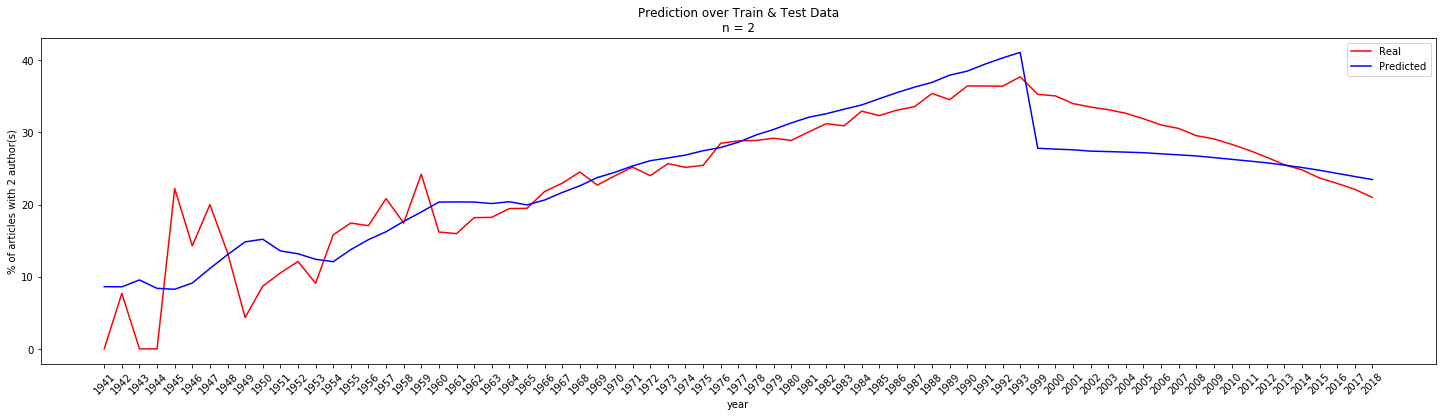

AVG MSE Err: 0.0016868098104704712

n = 3
Train Data
X: (53, 11, 1),	y: (53,)
Test Data
X: (20, 11, 1),	y: (20,)
Train on 37 samples, validate on 16 samples
Epoch 1/20
37/37 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 2/20
37/37 [==============================] - 0s 934us/step - loss: 4.4495e-04 - val_loss: 0.0046
Epoch 3/20
37/37 [==============================] - 0s 930us/step - loss: 3.5327e-04 - val_loss: 0.0020
Epoch 4/20
37/37 [==============================] - 0s 917us/step - loss: 1.5196e-04 - val_loss: 3.6722e-04
Epoch 5/20
37/37 [==============================] - 0s 938us/step - loss: 1.0414e-04 - val_loss: 3.5465e-04
Epoch 6/20
37/37 [==============================] - 0s 890us/step - loss: 1.1453e-04 - val_loss: 8.3049e-05
Epoch 7/20
37/37 [==============================] - 0s 893us/step - loss: 1.4948e-04 - val_loss: 4.2157e-04
Epoch 8/20
37/37 [==============================] - 0s 911us/step - loss: 1.0713e-04 - val_loss: 1.7181e

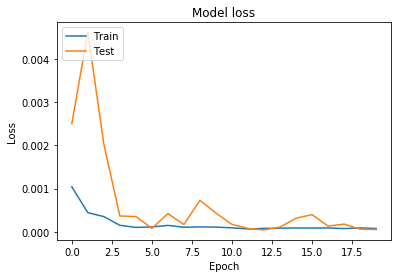

last train loss: 7.827383416116464e-05,	last test loss: 5.552680204345961e-05


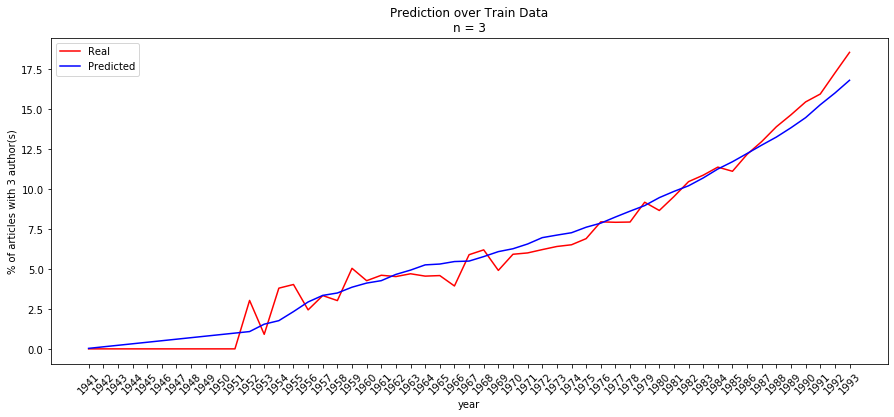

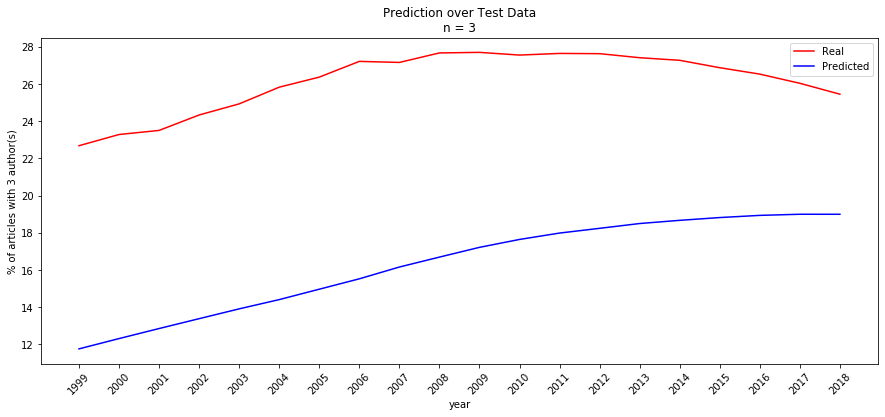

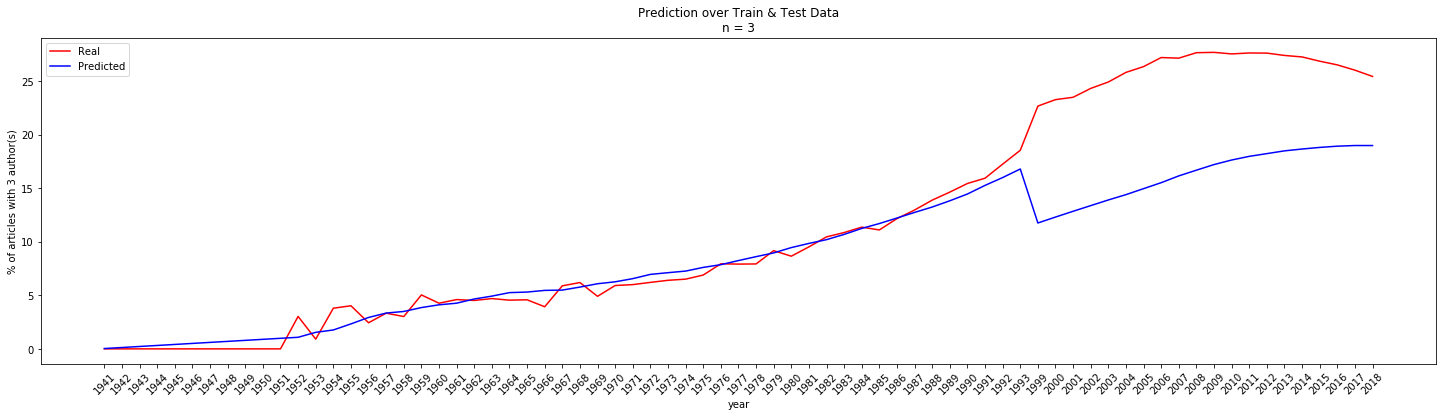

AVG MSE Err: 0.009944928283942717

n = 4
Train Data
X: (53, 11, 1),	y: (53,)
Test Data
X: (20, 11, 1),	y: (20,)
Train on 37 samples, validate on 16 samples
Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 1.3107e-04 - val_loss: 0.0013
Epoch 2/20
37/37 [==============================] - 0s 976us/step - loss: 6.6063e-05 - val_loss: 6.3125e-04
Epoch 3/20
37/37 [==============================] - 0s 998us/step - loss: 6.0174e-05 - val_loss: 8.0645e-04
Epoch 4/20
37/37 [==============================] - 0s 1ms/step - loss: 4.4633e-05 - val_loss: 4.0202e-04
Epoch 5/20
37/37 [==============================] - 0s 982us/step - loss: 3.7937e-05 - val_loss: 3.6872e-04
Epoch 6/20
37/37 [==============================] - 0s 967us/step - loss: 2.6612e-05 - val_loss: 1.8281e-04
Epoch 7/20
37/37 [==============================] - 0s 962us/step - loss: 2.7653e-05 - val_loss: 1.2704e-04
Epoch 8/20
37/37 [==============================] - 0s 977us/step - loss: 2.3003e-05 - val_loss

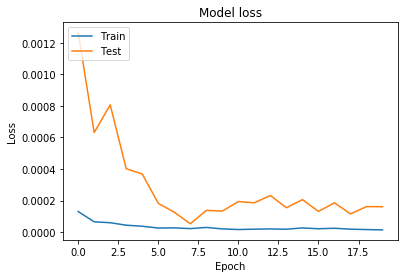

last train loss: 1.4708353405325937e-05,	last test loss: 0.0001614464858903375


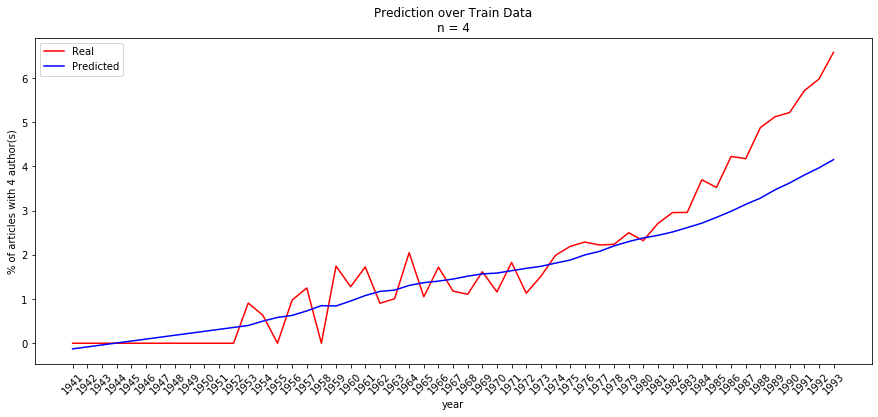

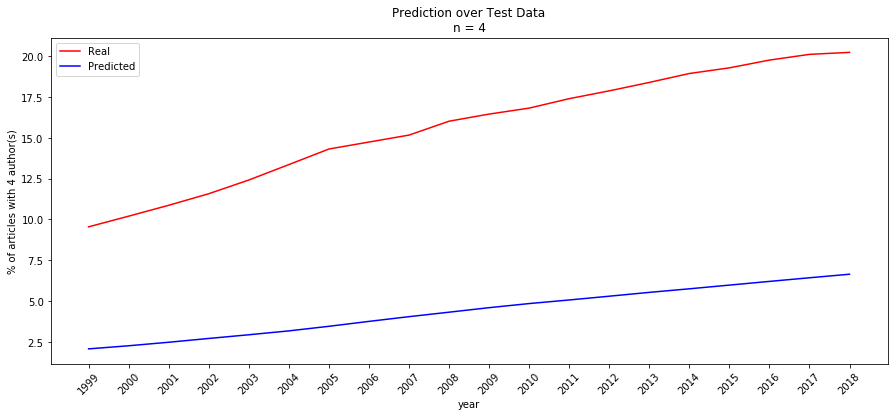

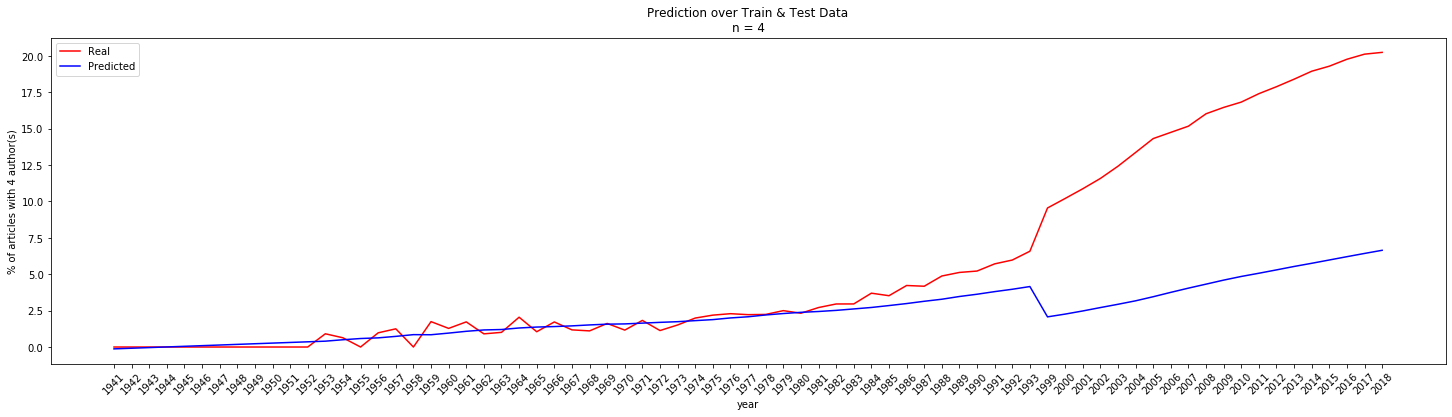

AVG MSE Err: 0.013146897959114258

n = 5
Train Data
X: (53, 11, 1),	y: (53,)
Test Data
X: (20, 11, 1),	y: (20,)
Train on 37 samples, validate on 16 samples
Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 8.6811e-05 - val_loss: 2.0512e-05
Epoch 2/20
37/37 [==============================] - 0s 943us/step - loss: 7.8926e-05 - val_loss: 2.6198e-04
Epoch 3/20
37/37 [==============================] - 0s 933us/step - loss: 5.1139e-05 - val_loss: 2.4823e-04
Epoch 4/20
37/37 [==============================] - 0s 957us/step - loss: 1.4314e-05 - val_loss: 6.7357e-05
Epoch 5/20
37/37 [==============================] - 0s 941us/step - loss: 2.7968e-05 - val_loss: 1.3043e-04
Epoch 6/20
37/37 [==============================] - 0s 917us/step - loss: 1.1692e-05 - val_loss: 2.4424e-04
Epoch 7/20
37/37 [==============================] - 0s 943us/step - loss: 1.7884e-05 - val_loss: 1.7291e-04
Epoch 8/20
37/37 [==============================] - 0s 887us/step - loss: 1.0575e-05 - va

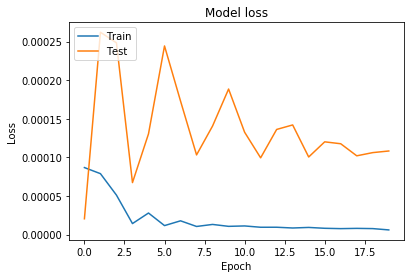

last train loss: 6.103698376898899e-06,	last test loss: 0.00010826685775100486


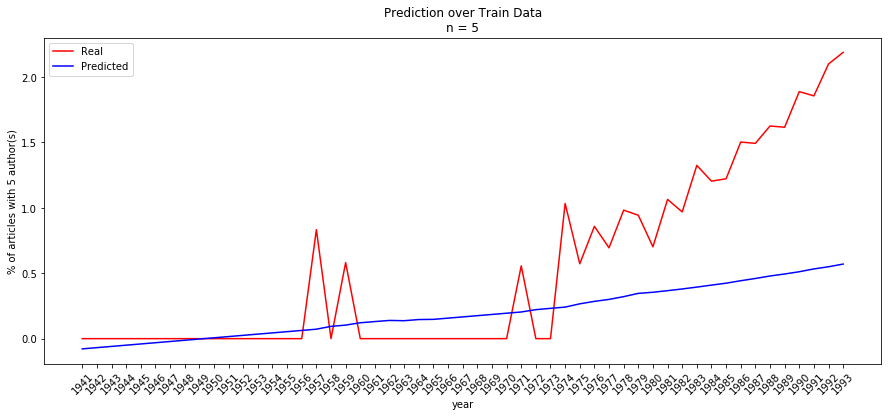

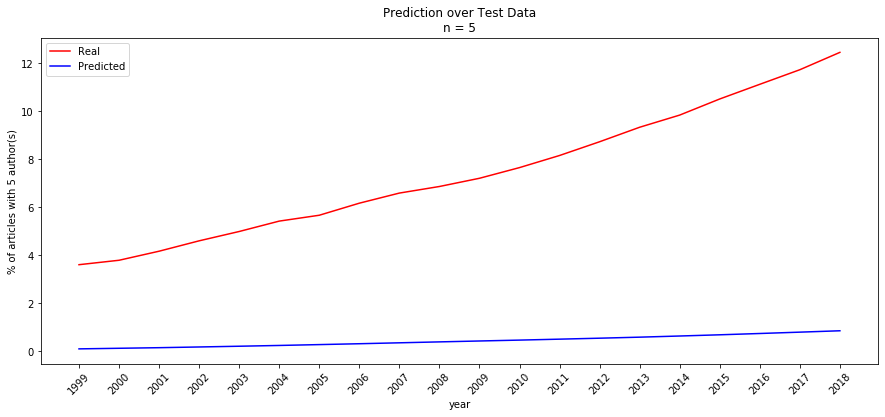

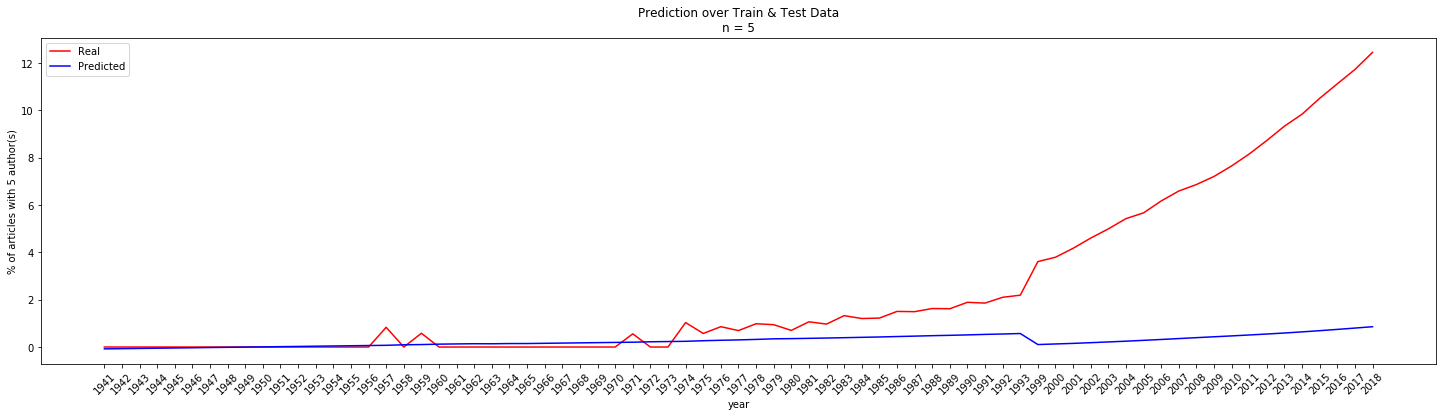

AVG MSE Err: 0.005479668809788995


AVG Total MSE Err: 0.013417015063035753


In [17]:
train_test_sep = 25
time_steps = 5

overall_err = predict(df, train_test_sep, time_steps)

In [18]:
overall_err

0.013417015063035753

## SVR

In [19]:
def get_data(df, n, window_size):
    n -= 1
    features = dict()
    res = dict()
    for year in range(1936 + window_size, 2019):
        feature = list()
        for feature_year in range(window_size, 0, -1):
            feature += list(df.loc[str(year - feature_year)].values)[n:n+1]
        feature += list(np.array(feature) * ((year - 1936) / 100))
        feature += [((year - 1936) / 100)]
        features[year] = feature
        res[year] = list(df.loc[str(year)])
    return features, res

In [20]:
def get_err(y_pred, y_test):
    return mean(np.square(y_pred - y_test))

In [21]:
def predict_one_svr(df, n, time_steps, test_num):
    print("n = %s" % n)
    
    features, res = get_data(df, n, time_steps)
        
    X = list(features.values())[:-test_num]
    print(len(X[0]))
    y = list(map(lambda l: l[n], list(res.values())))[:-test_num]

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=1e3, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=1e3, gamma=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, gamma=1e3, degree=3, epsilon=.1, coef0=1)
    
    errs = []

    lw = 2

    svrs = [svr_rbf, svr_lin, svr_poly]
    kernel_label = ['RBF', 'Linear', 'Polynomial']
    model_color = ['m', 'c', 'g']

    time_axis = np.arange(2019 - test_num, 2019)
#     time_axis = np.arange(1936 + time_steps, 2019)
    # time_axis = np.arange(1936 + time_steps, 2019 - test_num)

    fig, axes = plt.subplots(nrows=len(svrs), ncols=1, figsize=(15, 5 * len(svrs)), sharey=True)
    for ix, svr in enumerate(svrs):
        print("kernel: %s" % kernel_label[ix])
        y_pred = svr.fit(X, y).predict(list(features.values())[-test_num:])
        y_test = np.array(list(map(lambda l: l[n], list(res.values()))))[-test_num:]
        err = get_err(y_pred, y_test)
        errs.append(err)
        print("MSE Err: %s" % err)

        axes[ix].plot(time_axis, y_test * 100, color='k', lw=lw, label='expected')
        axes[ix].plot(time_axis, y_pred * 100, color=model_color[(ix) % len(model_color)], lw=lw, label='{} model'.format(kernel_label[ix]))
#         axes[ix].plot(time_axis, (y_pred - y_test) * 100, color=model_color[(ix+2) % len(model_color)], lw=lw, label='diff')
        axes[ix].legend()
    
    plt.show()
    print()
    return tuple(errs)

In [22]:
def predict_svr(df, time_steps, train_test_sep):
    errs_rbf, errs_lin, errs_poly = [], [], []
    
    for n in range(5):
        err_rbf, err_lin, err_poly = predict_one_svr(df, n + 1, time_steps, train_test_sep)
        errs_rbf.append(err_rbf)
        errs_lin.append(err_lin)
        errs_poly.append(err_poly)
    
    print("AVG MSE Err %s: %s" % ("RBF", mean(errs_rbf)))
    print("AVG MSE Err %s: %s" % ("Lin", mean(errs_lin)))
    print("AVG MSE Err %s: %s" % ("Poly", mean(errs_poly)))
    return mean(errs_rbf), mean(errs_lin), mean(errs_poly) 

n = 1
41
kernel: RBF
MSE Err: 0.004191411686175462
kernel: Linear
MSE Err: 0.003497722122378999
kernel: Polynomial
MSE Err: 0.0033906423927289576


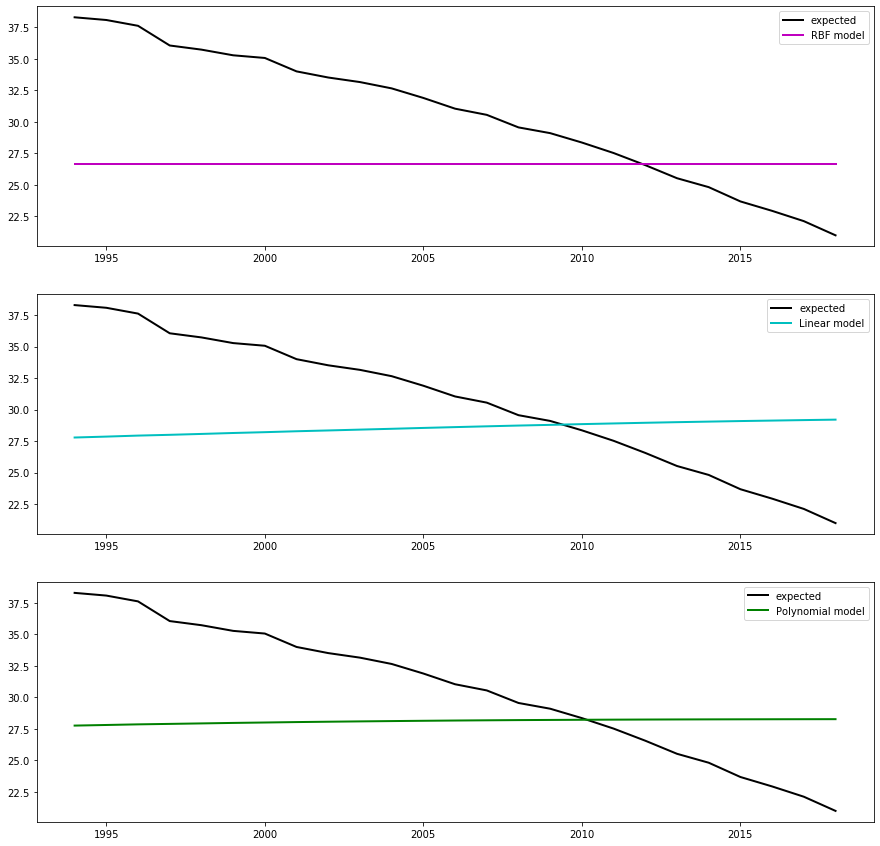


n = 2
41
kernel: RBF
MSE Err: 0.021912866706355758
kernel: Linear
MSE Err: 0.021912866706355758
kernel: Polynomial
MSE Err: 0.021912866706355758


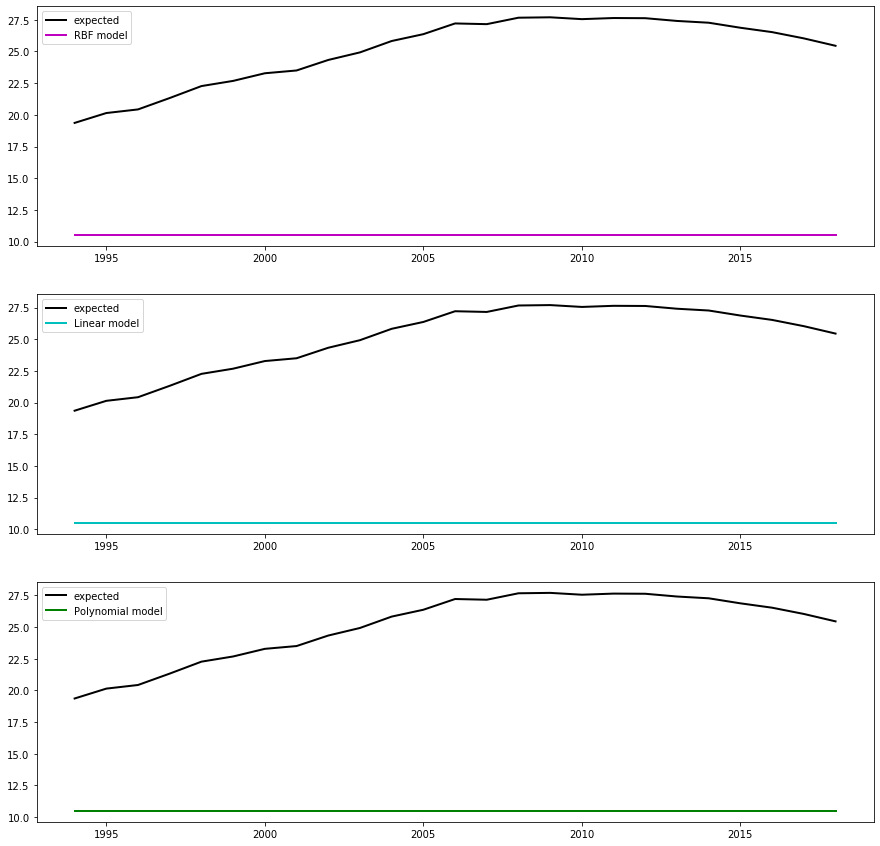


n = 3
41
kernel: RBF
MSE Err: 0.01364576354775579
kernel: Linear
MSE Err: 0.01364576354775579
kernel: Polynomial
MSE Err: 0.01364576354775579


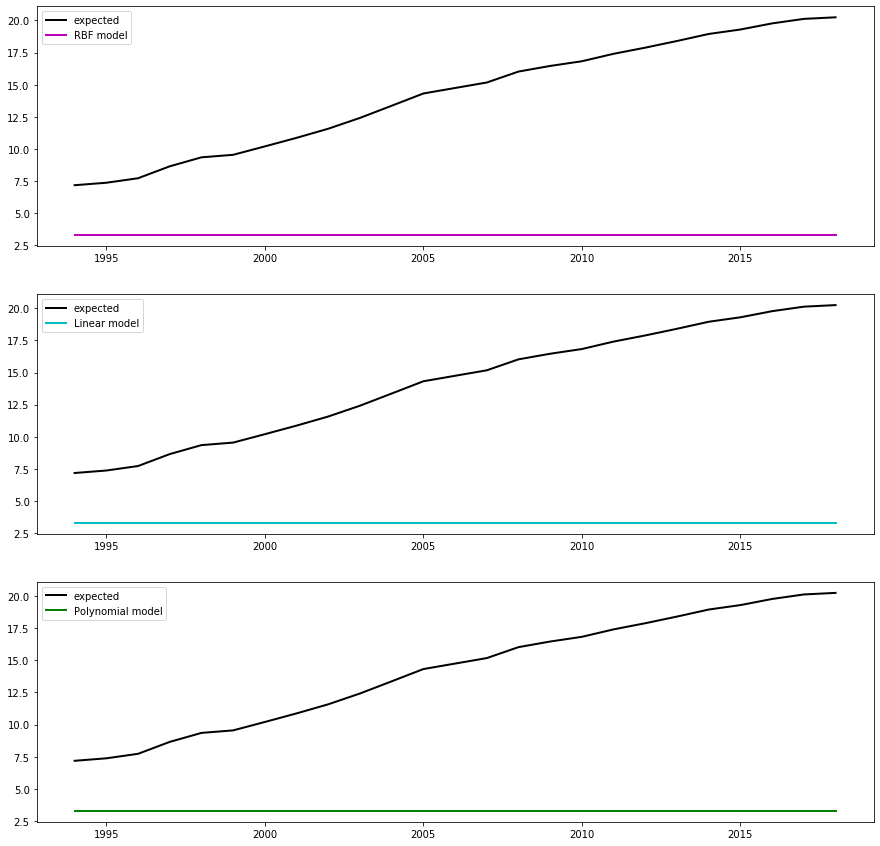


n = 4
41
kernel: RBF
MSE Err: 0.0038376259730649818
kernel: Linear
MSE Err: 0.0038376259730649818
kernel: Polynomial
MSE Err: 0.0038376259730649818


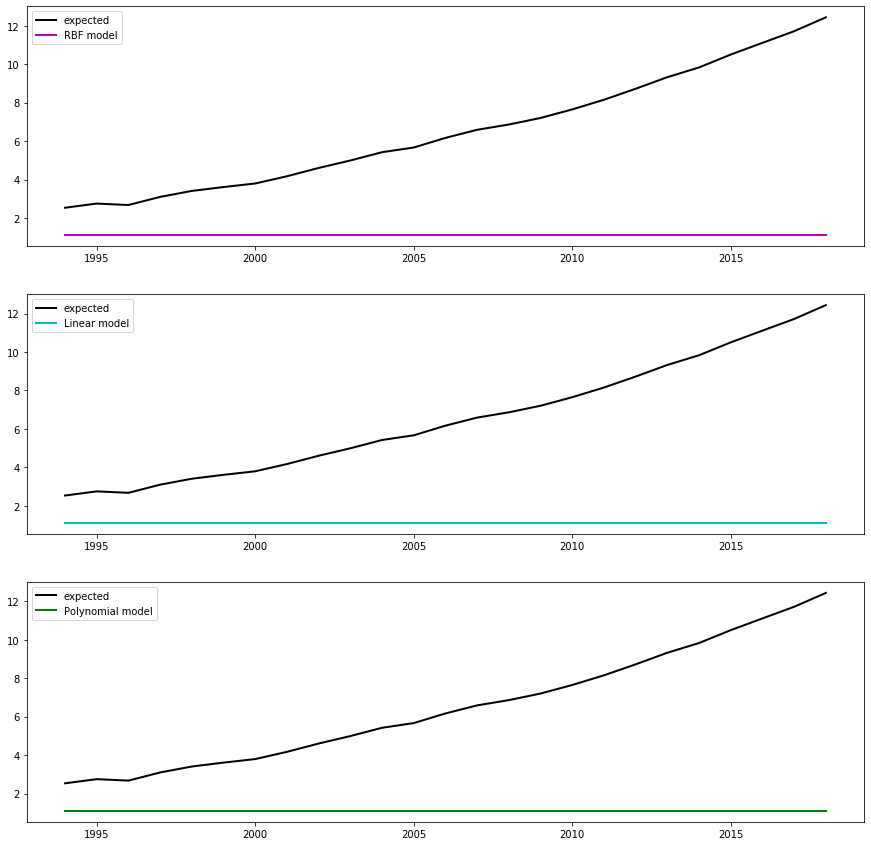


n = 5
41
kernel: RBF
MSE Err: 0.0008690006249123635
kernel: Linear
MSE Err: 0.0008690006249123635
kernel: Polynomial
MSE Err: 0.0008690006249123635


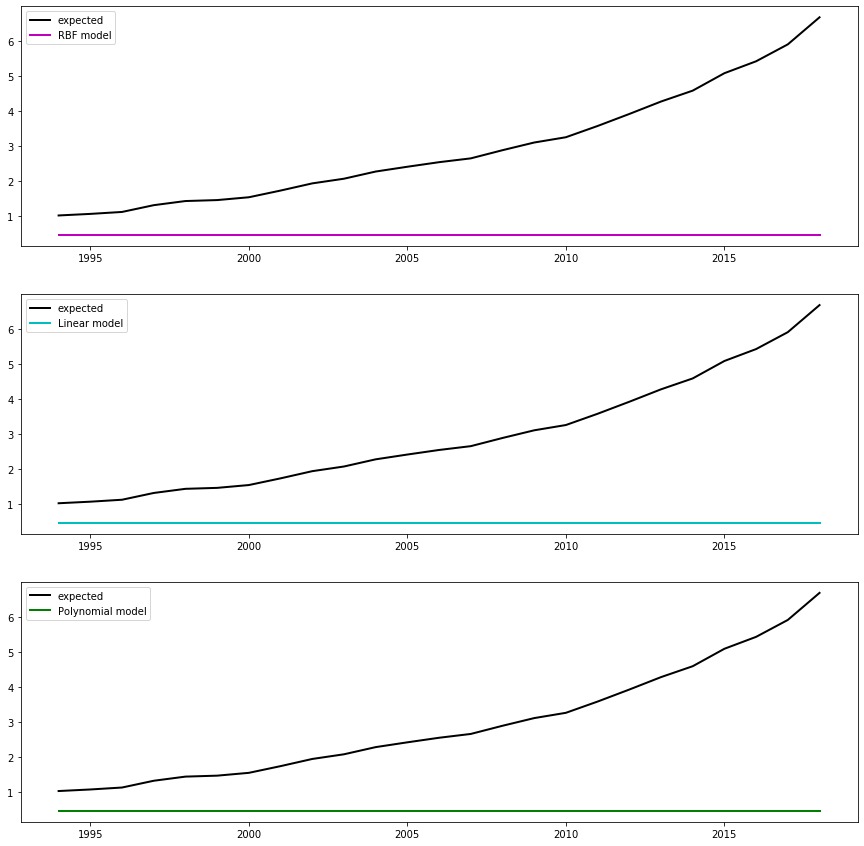


AVG MSE Err RBF: 0.008891333707652872
AVG MSE Err Lin: 0.008752595794893578
AVG MSE Err Poly: 0.00873117984896357


In [23]:
train_test_sep = 25
time_steps = 20
errs_rbf, errs_lin, errs_poly = predict_svr(df, time_steps, train_test_sep)

In [24]:
print(errs_rbf, errs_lin, errs_poly)

0.008891333707652872 0.008752595794893578 0.00873117984896357


## Year-based SVR

In [25]:
n = 1
prices = df[n]["1980":"2009"].values * 100
# dates = df.index.values
dates = np.arange(1980, 2010) - 2000

dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))
print(len(dates), len(prices))

new_prices = df[n]["2010":].values * 100
new_dates = np.arange(2010, 2019) - 2000

new_dates = np.reshape(new_dates, (len(new_dates), 1))
new_prices = np.reshape(new_prices, (len(new_prices), 1))
print(len(new_dates), len(new_prices))

30 30
9 9


In [26]:
svr_rbf_orig = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf_orig.fit(dates, prices)

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 1e100)
# svr_rbf = SVR(kernel='linear', C=100, gamma='auto')
# svr_rbf = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
svr_rbf.fit(dates, prices)

/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e+100,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

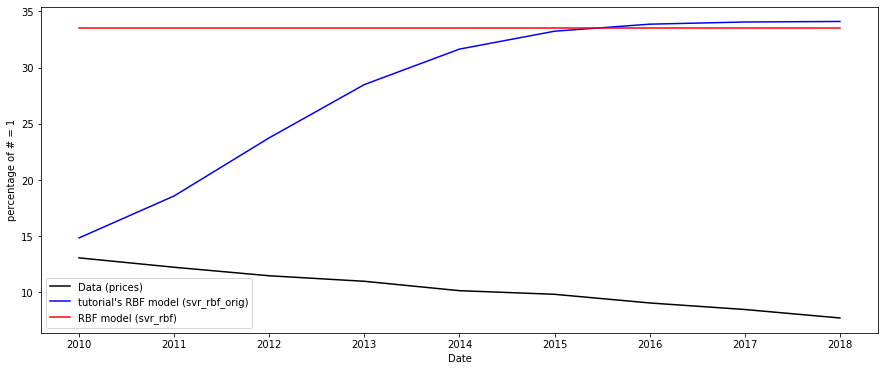

In [27]:
plt.figure(figsize = (15,6))
plt.plot(new_dates + 2000, new_prices, color= 'black', label= 'Data (prices)')
plt.plot(new_dates + 2000, svr_rbf_orig.predict(new_dates), color= 'blue', label= 'tutorial\'s RBF model (svr_rbf_orig)') 
plt.plot(new_dates + 2000, svr_rbf.predict(new_dates), color= 'red', label= 'RBF model (svr_rbf)') 
plt.xlabel('Date')
plt.ylabel('percentage of # = %d' % n)
plt.legend()
plt.show()
# np.concatenate(dates, new_dates)

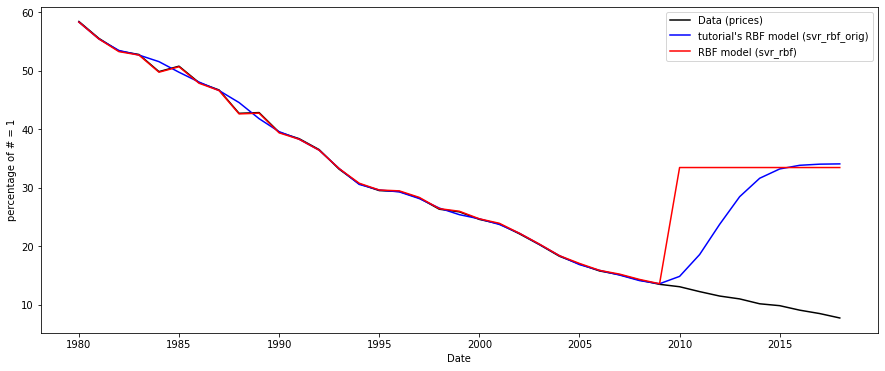

In [28]:
plt.figure(figsize = (15,6))
plt.plot(np.concatenate((dates, new_dates)) + 2000, np.concatenate((prices, new_prices)), color= 'black', label= 'Data (prices)')
plt.plot(np.concatenate((dates, new_dates)) + 2000, np.concatenate((svr_rbf_orig.predict(dates), svr_rbf_orig.predict(new_dates))), color= 'blue', label= 'tutorial\'s RBF model (svr_rbf_orig)') 
plt.plot(np.concatenate((dates, new_dates)) + 2000, np.concatenate((svr_rbf.predict(dates), svr_rbf.predict(new_dates))), color= 'red', label= 'RBF model (svr_rbf)') 
plt.xlabel('Date')
plt.ylabel('percentage of # = %d' % n)
plt.legend()
plt.show()
# np.concatenate(dates, new_dates)